In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import random
import itertools

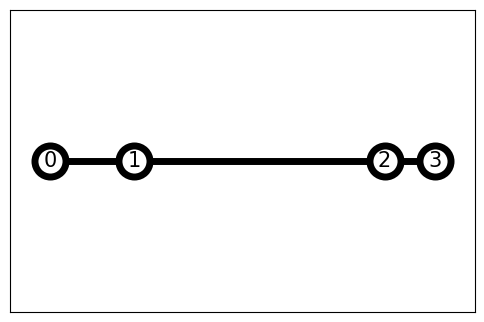

In [2]:
#setup grid
fig,ax=plt.subplots(dpi=100)

#create graph
G = nx.Graph()

#give in node list
nodes=[0,1,2,3]

#edge weights (dist in between)
dist=[50,150,30]


#make weighted edge list to add, then fill
edges=[]
for i in range(len(nodes)-1):
    edges.append((nodes[i],nodes[i+1],dist[i]))
    
#add weighted edges
G.add_weighted_edges_from(edges)

#explicitly set positions to match distances (just for visualization)
#first node is at (0,0)
pos_dict={0:(0,0)}
#other nodes are at summed dist to the right
for i in range(len(dist)):
    pos_dict[(i+1)]=(sum(dist[:(i+1)]),0)

#plotting options
options = {
    "font_size": 15,
    "node_size": 500,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 5,
    "width": 5,
}

#plot
nx.draw_networkx(G, pos=pos_dict, **options, labels={node: node for node in G.nodes()})

In [3]:
#this script is copied from: https://stackoverflow.com/questions/50634876/how-can-you-remove-superset-lists-from-a-list-of-lists-in-python
def get_minimal_subsets(sets):
    sets = sorted(map(set, sets), key=len)
    minimal_subsets = []
    for s in sets:
        if not any(minimal_subset.issubset(s) for minimal_subset in minimal_subsets):
            minimal_subsets.append(s)
    #added, converge to tuple
    tuples_inside = [tuple (k) for k in minimal_subsets]

    return tuples_inside

In [7]:


def FRLM(G, n, r, OD):
    """ 
    Returns optimal locations for n stations on network G, considering travel range r and OD_data. 
    Parameters
    ----------
    G : NetworkX graph
        must include all origins, desinations and any nodes where a refueling station may be placed.
    n : int
        #stations to locate on any node of G.
    r : float
        range means of transport with full tank.
    OD: list 
        list of travel data within network G, travel data form A-B and from B-A should be summed up and entered as either one of them.
        example input:
        [(origin_1, destination_2, flow_12),(origin_1, destination_3, flow_13),(origin_2, destination_3, flow_23)]
        """
    #get data from graph in list format
    node_list = [i for i in G.nodes]
    edge_list = [i for i in G.edges]
    edge_list_w = []
    
    # Now also create weighted edge list in the format [(begin, start, weight),(..), etc.]
    for i in edge_list:
        edge_list_w.append((i[0],i[1],G.get_edge_data(i[0],i[1])['weight']))
    # print(edge_list_w)
    
    #collect paths to refuel and path lengths in dicts, first create empty dicts
    paths = {}
    path_lengths = {}
    
    #generate shortest paths for al origin destinations
    for path in OD:
        # print(path)
        paths[(path[0],path[1])] = nx.dijkstra_path(G,path[0],path[1])
        path_lengths[(path[0],path[1])] = nx.dijkstra_path_length(G,path[0],path[1],weight='weight')
    
    
    #make master dict with key=OD, that contains a list of all fuel station combinations combinations on that route that are possible
    route_refuel_comb = {}
    for i in paths.items():
        h=[]
        # #check if single station is enough
        # if r >= path_lengths[i[0]]:
        #     print(i[1])
        #     h = [tuple (k) for k in str(i[1])]
        #     route_refuel_comb[i[0]] = h
        # else:
        # create all possible station combinations on this path
        for L in range (0, len(i[1])+1):
                for j in itertools.combinations(i[1], (L+1)):
                    # print(j)
                    h.append(j)
        #now add to dict:
        route_refuel_comb[i[0]] = h
        
    #now evaluate all of these combinations, for each route check feasibility of each combination based on range
    feasible_combinations = {}
    
    for route in route_refuel_comb.items():
        feasible_combinations[route[0]] = []
        #store path for this route (on which round trip should be feasible) 
        path = paths[route[0]]
        # print('Evaluate options for route', path)
        # print('Combinations to evaluate:', route[1])
        round_trip = path[:-1] + path[::-1]
        
        #now loop through all possible station combinations
        for combi in route[1]:
            # print('Evaluate combination', combi)
            #start at origin
            current_pos = round_trip[0]
                                
            #start with full range if refueling station at origin, otherwise half.
            if current_pos in combi:
                current_range = r
            else:
                current_range = r*0.5
            #simulate fuel during round trip, first dest is second entry roundtrip list                    
            for sub_dest in round_trip[1:]:
                print(current_pos,sub_dest)
#               #try to travel to new dest
                # print('Current range =', current_range, 'now evaluate edge:',(current_pos,sub_dest))
                #calculate dist to new destination
                dist = G.get_edge_data(current_pos,sub_dest)['weight']
                #only travel if dist is not too long
                if (current_range - dist) >= 0:
                    #final dest reached?
                    #if there is fuel station at destination: trip feasible
                    if (sub_dest in combi):
                        if (sub_dest == path[-1]):
                            print('Trip', path, 'successful with layout', combi)
                            feasible_combinations[route[0]].append(combi)
                            break
                    #else: maybe feasible, double back route to check!
                    else:
                        if (sub_dest == path[0]):
                            print('Trip', path, 'successful with layout', combi)
                            feasible_combinations[route[0]].append(combi)
                            break
                    #if not at final destination update range and pos
                    current_pos = sub_dest
                    current_range -= dist
                    #if there is a refueling station, refuel
                    if sub_dest in combi:
                        current_range = r
                    #check if at final dest
                else:
                    print('Trip', path, 'not feasible with layout', combi)
                    break
    
    #next: find and remove supersets
    for i in feasible_combinations.items():
        feasible_combinations[i[0]] = get_minimal_subsets(feasible_combinations[i[0]])
    
    #last step, create two dicts to make two dfs as described in paper (reformat data)
    #first create list of all possible combinations
    combinations=[]
    for i in feasible_combinations.values():
        combinations+=i
    
    #setup empty dict with keys to fill for dict 1
    binary_dict_pc = {'Route':[]}
    for j in combinations:
            binary_dict_pc[j] = []
    
    #fill dictionary
    for i in feasible_combinations.items():
        binary_dict_pc['Route'].append(i[0])
        for j in combinations:
            if j in i[1]:
                binary_dict_pc[j].append(1)
            else:
                binary_dict_pc[j].append(0)
    
    #next dict: combinations and facilities
    slist = [item for sublist in combinations for item in sublist]
    facilities=list(set(slist))
    binary_dict_fc={'Combinations':combinations}
    for j in facilities:
        binary_dict_fc[j] = []
    for i in combinations:
        for j in facilities:
            if j in i:
                binary_dict_fc[j].append(1)
            else:
                binary_dict_fc[j].append(0)


    return(binary_dict_pc, binary_dict_fc)
    
         
    

In [10]:
import time

%time dict_df1, dict_df2 = FRLM(G, 1, 350, [(0,3,10),(0,2,5)])

0 1
1 2
2 3
3 2
2 1
Trip [0, 1, 2, 3] not feasible with layout (0,)
0 1
1 2
2 3
3 2
2 1
Trip [0, 1, 2, 3] not feasible with layout (1,)
0 1
1 2
Trip [0, 1, 2, 3] not feasible with layout (2,)
0 1
1 2
Trip [0, 1, 2, 3] not feasible with layout (3,)
0 1
1 2
2 3
3 2
2 1
Trip [0, 1, 2, 3] not feasible with layout (0, 1)
0 1
1 2
2 3
3 2
2 1
1 0
0 1
1 2
2 3
Trip [0, 1, 2, 3] successful with layout (0, 3)
0 1
1 2
2 3
3 2
2 1
1 0
Trip [0, 1, 2, 3] successful with layout (1, 2)
0 1
1 2
2 3
Trip [0, 1, 2, 3] successful with layout (1, 3)
0 1
1 2
Trip [0, 1, 2, 3] not feasible with layout (2, 3)
0 1
1 2
2 3
3 2
2 1
1 0
0 1
1 2
2 3
Trip [0, 1, 2, 3] successful with layout (0, 1, 3)
0 1
1 2
2 3
Trip [0, 1, 2, 3] successful with layout (0, 2, 3)
0 1
1 2
2 3
Trip [0, 1, 2, 3] successful with layout (1, 2, 3)
0 1
1 2
2 3
Trip [0, 1, 2, 3] successful with layout (0, 1, 2, 3)
0 1
1 2
2 1
1 0
Trip [0, 1, 2] not feasible with layout (0,)
0 1
1 2
2 1
1 0
Trip [0, 1, 2] successful with layout (1,)
0 1
1 2
T

In [11]:
pd.DataFrame.from_dict(dict_df1)

,Route,"(0, 3)","(1, 2)","(1, 3)","(1,)","(0, 2)"
0,"(0, 3)",1,1,1,0,0
1,"(0, 2)",0,0,0,1,1


In [12]:
pd.DataFrame.from_dict(dict_df2)

,Combinations,0,1,2,3
0,"(0, 3)",1,0,0,1
1,"(1, 2)",0,1,1,0
2,"(1, 3)",0,1,0,1
3,"(1,)",0,1,0,0
4,"(0, 2)",1,0,1,0
